In [269]:
import pandas as pd

df = pd.read_csv('../jungler_data.csv')

1. Data Exploration

In [270]:
df.shape

(3053, 13)

In [271]:
df.columns

Index(['kills_first_4_min', 'assists_first_4_min', 'camps_cleared_first_4_min',
       'gold_earned_first_4_min', 'win', 'kills_details', 'summoner_spells',
       'champion', 'first_item', 'level_at_first_blood', 'firstBlood',
       'gold_per_minute', 'game_type'],
      dtype='object')

In [272]:
df.head

<bound method NDFrame.head of       kills_first_4_min  assists_first_4_min  camps_cleared_first_4_min  \
0                     0                    0                         28   
1                     0                    0                         24   
2                     0                    0                         28   
3                     0                    0                         28   
4                     1                    0                         24   
...                 ...                  ...                        ...   
3048                  1                    0                         19   
3049                  1                    0                         20   
3050                  1                    0                         16   
3051                  0                    0                         12   
3052                  1                    0                         24   

      gold_earned_first_4_min    win kills_details summoner_spells ch

In [273]:
df.dtypes

kills_first_4_min              int64
assists_first_4_min            int64
camps_cleared_first_4_min      int64
gold_earned_first_4_min        int64
win                             bool
kills_details                 object
summoner_spells               object
champion                      object
first_item                    object
level_at_first_blood           int64
firstBlood                      bool
gold_per_minute              float64
game_type                     object
dtype: object

2. Data Preprocessing

We only care about Ranked Solo/Duo games, since these games are more competative than other game types

In [274]:
ranked_only_df = df[df['game_type'] == 'Ranked Solo/Duo']

In [275]:
ranked_only_df.head

<bound method NDFrame.head of       kills_first_4_min  assists_first_4_min  camps_cleared_first_4_min  \
0                     0                    0                         28   
1                     0                    0                         24   
4                     1                    0                         24   
5                     1                    0                         20   
6                     0                    0                         16   
...                 ...                  ...                        ...   
3048                  1                    0                         19   
3049                  1                    0                         20   
3050                  1                    0                         16   
3051                  0                    0                         12   
3052                  1                    0                         24   

      gold_earned_first_4_min    win kills_details summoner_spells  c

In [276]:
ranked_only_df.shape

(2190, 13)

We still have 2190 Games to use, thats Great!
Lets check for duplicates

In [277]:
duplicates = ranked_only_df[ranked_only_df.duplicated()]
print(duplicates)

      kills_first_4_min  assists_first_4_min  camps_cleared_first_4_min  \
180                   0                    0                         28   
305                   0                    0                         28   
307                   0                    0                         28   
314                   0                    0                         28   
356                   0                    0                         28   
...                 ...                  ...                        ...   
2878                  0                    0                         28   
2940                  0                    0                         28   
2957                  0                    0                         28   
3015                  0                    0                         28   
3036                  0                    0                         28   

      gold_earned_first_4_min    win kills_details summoner_spells  champion  \
180                

380 Duplicates!!! Looks like our script had some overlap in the matches we recorded.

Lets Drop these entries

In [278]:
clean_df = ranked_only_df.drop_duplicates()

In [279]:
#Error Checking
print(len(ranked_only_df) - len(clean_df))

380


Our summoner_spells column can use some cleaning, since all entries have 11 in it, that is a constant, we only care about the summoner_spell that is not 11

In [280]:
def extract_spell(spell_str):
    spell_str = spell_str.strip('()')
    spell_list = spell_str.split(',')
    return int(spell_list[1]) if int(spell_list[0]) == 11 else int(spell_list[0])

reformatted_df  =  clean_df.copy()

In [281]:
# Apply the function to the Summoner_spells column
reformatted_df['secondary_summoner_spell'] = reformatted_df['summoner_spells'].apply(extract_spell)

# Drop the old column
reformatted_df.drop(columns=['summoner_spells'], inplace=True)

In [282]:
reformatted_df['secondary_summoner_spell']

0       4
1       4
4       4
5       4
6       4
       ..
3048    4
3049    4
3050    4
3051    4
3052    4
Name: secondary_summoner_spell, Length: 1810, dtype: int64

In [283]:
missing_values = reformatted_df.isnull().sum()
print(missing_values)

kills_first_4_min            0
assists_first_4_min          0
camps_cleared_first_4_min    0
gold_earned_first_4_min      0
win                          0
kills_details                0
champion                     0
first_item                   0
level_at_first_blood         0
firstBlood                   0
gold_per_minute              0
game_type                    0
secondary_summoner_spell     0
dtype: int64


In [284]:
#Drop game_type column since they are all the same now
reformatted_df = reformatted_df.drop(columns='game_type')

Since I would Like to use a nueral network we have to encode some of our columns

In [285]:
reformatted_df.dtypes

kills_first_4_min              int64
assists_first_4_min            int64
camps_cleared_first_4_min      int64
gold_earned_first_4_min        int64
win                             bool
kills_details                 object
champion                      object
first_item                    object
level_at_first_blood           int64
firstBlood                      bool
gold_per_minute              float64
secondary_summoner_spell       int64
dtype: object

In [286]:
from sklearn.preprocessing import LabelEncoder

le_first_item = LabelEncoder()
le_champion = LabelEncoder()

reformatted_df['first_item_encoded'] = le_first_item.fit_transform(reformatted_df['first_item'])
reformatted_df['champion_encoded'] = le_champion.fit_transform(reformatted_df['champion'])

print(reformatted_df[['first_item', 'first_item_encoded', 'champion', 'champion_encoded']].head())



  first_item  first_item_encoded  champion  champion_encoded
0    No Item                   2   Shyvana                55
1       Blue                   0     Viego                68
4        Red                   3      Kayn                23
5        Red                   3  Nocturne                42
6      Green                   1     Amumu                 0


In [287]:
print(reformatted_df['champion_encoded'])

0       55
1       68
4       23
5       42
6        0
        ..
3048    50
3049    12
3050     3
3051    25
3052    30
Name: champion_encoded, Length: 1810, dtype: int32


In [288]:
reformatted_df = reformatted_df.drop(columns=['first_item', 'champion'])

In [289]:
#Change kill details to first_kill_time, which records the timestamp of the junglers first kill of the game
reformatted_df['first_kill_time'] = reformatted_df['kills_details'].apply(lambda x: int(eval(x)[0]) if eval(x) else 0)
reformatted_df = reformatted_df.drop(columns=['kills_details'])


In [290]:
reformatted_df.dtypes

kills_first_4_min              int64
assists_first_4_min            int64
camps_cleared_first_4_min      int64
gold_earned_first_4_min        int64
win                             bool
level_at_first_blood           int64
firstBlood                      bool
gold_per_minute              float64
secondary_summoner_spell       int64
first_item_encoded             int32
champion_encoded               int32
first_kill_time                int64
dtype: object

Now that our Data is cleaned and reformated and encoded, we have to split the data so that our model can Train and Test

In [291]:
from sklearn.model_selection import train_test_split

X = reformatted_df.drop(columns=['win'])  # Features
y = reformatted_df['win']  # Target

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [292]:
print(f"Training features shape: {X_train.shape}")
print(f"Test features shape: {X_test.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Test target shape: {y_test.shape}")

Training features shape: (1448, 11)
Test features shape: (362, 11)
Training target shape: (1448,)
Test target shape: (362,)


3. Model Creation

In [293]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

# X_train: features, y_train: target variable

model = Sequential([
    # Input layer
    Input(shape=(X_train.shape[1],)),

    # Hidden layers
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dropout(0.3),  
    Dense(16, activation='relu'),

    # Output layer
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train,
                    epochs=20,  
                    batch_size=32,  
                    validation_split=0.2)  # Use a portion of data for validation

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)  
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')


Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5021 - loss: 2485.9319 - val_accuracy: 0.4759 - val_loss: 61.7495
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4768 - loss: 335.0354 - val_accuracy: 0.4759 - val_loss: 11.3808
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5262 - loss: 239.9062 - val_accuracy: 0.4621 - val_loss: 25.1229
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5221 - loss: 177.1137 - val_accuracy: 0.5241 - val_loss: 11.9496
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5164 - loss: 86.8238 - val_accuracy: 0.5172 - val_loss: 5.3549
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5276 - loss: 28.2445 - val_accuracy: 0.4828 - val_loss: 7.7227
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5072 - loss: 17.5785 - val_accuracy: 0.5069 - val_loss: 0.7598
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4896 - loss: 1.2436 - val_accuracy: 0.

Wow not a great outcome for out first run, model is underfitting

Some thoughts for improvement:

Get rid of the champion feature, since there is a big variety and may have little corelation/importance in this instance

Adjust hyperparameters

4. Model Tuning

In [294]:
new_df = reformatted_df.drop(columns=['champion_encoded'])

In [295]:
new_df.dtypes

kills_first_4_min              int64
assists_first_4_min            int64
camps_cleared_first_4_min      int64
gold_earned_first_4_min        int64
win                             bool
level_at_first_blood           int64
firstBlood                      bool
gold_per_minute              float64
secondary_summoner_spell       int64
first_item_encoded             int32
first_kill_time                int64
dtype: object

In [296]:
X = new_df.drop(columns=['win'])  # Features
y = new_df['win']  # Target

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [297]:
model = Sequential([
    # Input layer
    Input(shape=(X_train.shape[1],)),

    # Hidden layers
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dropout(0.3),  
    Dense(16, activation='relu'),

    # Output layer
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train,
                    epochs=40,  # Adjust the number of epochs as needed
                    batch_size=32,  # Adjust batch size as needed
                    validation_split=0.2)  # Use a portion of data for validation

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)  # Assuming you have test data
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')

Epoch 1/40
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4890 - loss: 2110.6670 - val_accuracy: 0.4759 - val_loss: 212.1687
Epoch 2/40
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5143 - loss: 550.0527 - val_accuracy: 0.4759 - val_loss: 160.2881
Epoch 3/40
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4986 - loss: 489.4833 - val_accuracy: 0.4759 - val_loss: 7.8827
Epoch 4/40
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4957 - loss: 233.3166 - val_accuracy: 0.4793 - val_loss: 191.0955
Epoch 5/40
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5104 - loss: 198.9562 - val_accuracy: 0.5241 - val_loss: 75.2019
Epoch 6/40
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5234 - loss: 81.6519 - val_accuracy: 0.5172 - val_loss: 28.2100
Epoch 7/40
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4984 - loss: 52.6137 - val_accuracy: 0.5276 - val_loss: 2.2526
Epoch 8/40
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4725 - loss: 43.4267 - val_accura

Better results without using champion, and increasing number of epochs to 40

In [302]:
from tensorflow.keras.layers import BatchNormalization

model = Sequential([
    # Input layer
    Input(shape=(X_train.shape[1],)),

    # Hidden layers
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    # Output layer
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.02),  # Adjust learning rate
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2,
                    )

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {loss}')
print(f'Test accuracy: {accuracy}')


Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4782 - loss: 0.7927 - val_accuracy: 0.4828 - val_loss: 1.1040
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5077 - loss: 0.7168 - val_accuracy: 0.4759 - val_loss: 1.3060
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5119 - loss: 0.7083 - val_accuracy: 0.4828 - val_loss: 0.9187
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5318 - loss: 0.6953 - val_accuracy: 0.4793 - val_loss: 0.7310
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4843 - loss: 0.7076 - val_accuracy: 0.4897 - val_loss: 0.7123
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5193 - loss: 0.7037 - val_accuracy: 0.5241 - val_loss: 0.7049
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5429 - loss: 0.6905 - val_accuracy: 0.5483 - val_loss: 0.6909
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5582 - loss: 0.6896 - val_accuracy: 0.5310 - val_loss:

Added Batch Normalization to generalize better, also allowing for the use of higher learning rates

Getting accuracy of 55%!!

Also we know that the model is not to overfit since, the val_accuracy and accuracy are similar

A good winrate in league of legends is above 50% so I am happy with this result, especially since league games last about 10x longer than the data we are looking at

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Classification Report:
              precision    recall  f1-score   support

    Loss (0)       0.51      0.68      0.58       167
     Win (1)       0.62      0.44      0.51       195

    accuracy                           0.55       362
   macro avg       0.56      0.56      0.55       362
weighted avg       0.57      0.55      0.54       362



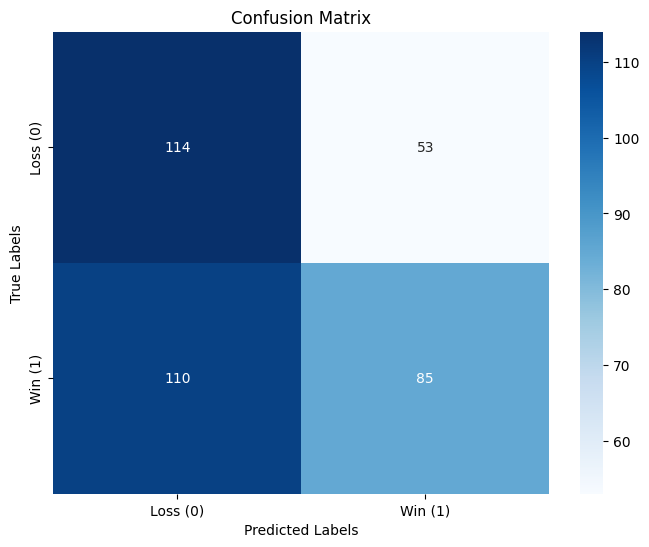

In [303]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on test data
y_pred = model.predict(X_test)  # Predict probabilities
y_pred_classes = (y_pred > 0.5).astype(int)  # Convert probabilities to class labels

# Generate classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=['Loss (0)', 'Win (1)']))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Loss (0)', 'Win (1)'], 
            yticklabels=['Loss (0)', 'Win (1)'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
